In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Newton Divided Difference

In [2]:
def PlotNewtonInterpolation(X, interval, F, num_samples = 50, title=""):
    interPX = list(np.linspace(interval[0], interval[1], num_samples))
    interPY = [NewtonInterpolate(X, F, x) for x in interPX]

    plt.figure(figsize=(10,5))
    plt.grid()
    plt.title(title)
    plt.plot(interPX, interPY,label="Interpolated")
    plt.legend()

In [3]:
"""
@params:
X = sampled points
F = divided difference coefs
x = value to be interpolated

@brief:
This Functions generates the Newton Polynomial and computes the 
interpolated value according the the Newton Divided Difference Algorithm

@return: It returns the interpolated value.
"""
def NewtonInterpolate(X, F, x):
    int_val=0  #interpolated value

    for i in range(0,len(X)):
        prod = 1
        #This loops generates (x-x0)*(x-x1)*....*(x-xi)
        for j in range(i):
            prod *= (x-X[j])

        int_val += (F[i]*prod)      # it computes F[i] * (x-x0)*(x-x1)*....*(x-xi) and adds into Previous calculations
                                    # This creates a Polynomial
    return int_val


In [4]:
"""
@params:
x = sampled points
y = function values at sampled points
get_Nth_divDff = this is used if we need to get some specified layer/Nth divided difference as whole.
                 this will only do div diff upto that layer and then return that entire layer.
@brief:
This Functions generates the Newton Divided Difference Coefiecents.

@return: return a list of Divided Difference Coeficients
                OR
         return a list of values of a particular order of divided difference 
"""
def NewtonDivDiff(x, y, get_Nth_divDff = 0):
    F = y                   #The F[xi] = f(xi) = yi
    forward_ret = [F[0]]    #The returning elements. These are the top elements that make up divided different coefiecients.

    for i in range(1,len(x)):
        nF = [] 
        for j in range(1,len(F)):
            nF.append( (F[j]-F[j-1])/(x[j+i-1]-x[j-1]) )      #Computing the F[xi....xi+k] = (F[xi+1...xi+k] - F[xi...xi+k-1]) / (xi+k - xi)

        F = nF      #Just holding the previous Layer values. Because we only need this much
        ## this is just checking if we need to return some specified order divided difference or not
        if(get_Nth_divDff == i):
            return F
        forward_ret.append(F[0])

    return forward_ret

## Newton divided Difference TEST examples

[-6.0, 1.051700000000002, 0.5724999999999832, 0.21500000000004166, 0.06301587301582073]
-5.508191238095238


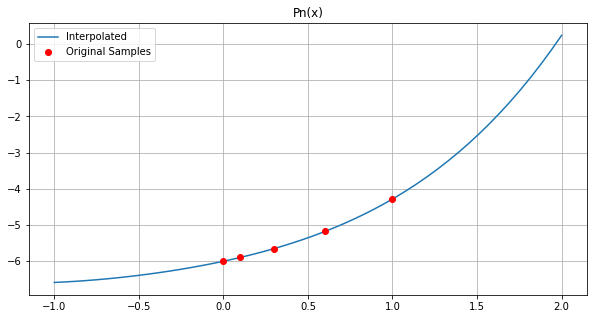

In [5]:
x = [0.0, 0.1, 0.3, 0.6, 1]
y = [-6.0, -5.89483, -5.65014, -5.17788, -4.28172]

div_diff_coef = NewtonDivDiff(x,y)
print(div_diff_coef)
print(NewtonInterpolate(x,div_diff_coef, 0.4))
PlotNewtonInterpolation(x, (-1,2), div_diff_coef, title="Pn(x)")
plt.plot(x,y, "ro",label="Original Samples")
plt.legend()
plt.show()

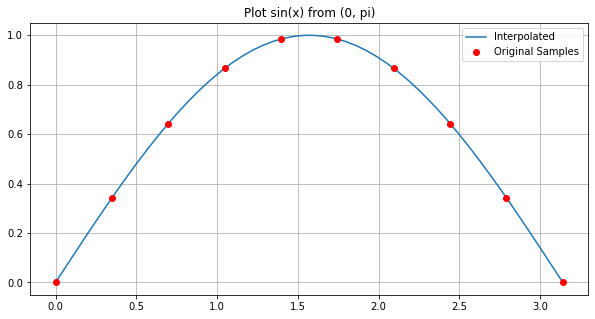

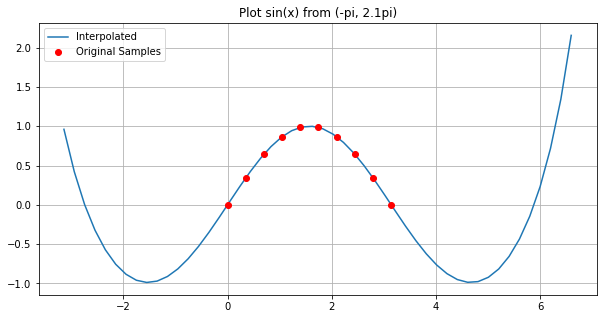

In [6]:
X = np.linspace(0, np.pi, 10)
sinX = np.sin(X)

F = NewtonDivDiff(X, sinX)

PlotNewtonInterpolation(X, (0, np.pi), F, title="Plot sin(x) from (0, pi)")
plt.plot(X, np.sin(X), "ro",label="Original Samples")
plt.legend()
plt.show()

PlotNewtonInterpolation(X, (-np.pi, 2.1*np.pi), F, title="Plot sin(x) from (-pi, 2.1pi)")
plt.plot(X, sinX, "ro",label="Original Samples")
plt.legend()
plt.show()

# Cubic Splines

In [34]:
"""
@params:
x = sampled data points
y = function values at sampled points
bound_cond = a tuple containing the boundary value condition values. these are by default set to 0 for natural splines

@breif:
This function computes the values of Mi (the unknowns in the second derivative of spline functions)
Mi's are calculated by forming a matrix forms like:
__                                  __   _   __   __                          __
|1   0   0  . . . . . . . . . . . . 0|   | M0 |   |             0               |
|u1  2  1-u1  0 . . . . . . . . . . 0|   | M1 |   | 6*F[x[0], x[1], x[2]]       |
|0   u2  2  1-u2  0 . . . . . . . . 0|   | .. |   | 6*F[x[1], x[2], x[3]]       |
|    .  . . . . .                    | * | .. | = |      ...                    |                   ==> for Natural Spline
|        . . . . . .                 |   | .. |   |      ...                    |
|0 . . . . . . u[n-1]  2  1-u[n-1]  0|   | .. |   | 6*F[x[n-3], x[n-2], x[n-1]] |
|0 . . . . . . . . .  u[n]  2  1-u[n]|   |Mn-1|   | 6*F[x[n-2], x[n-1], x[n]]   |
|0 . . . . . . . . . . . . . .  0   1|   | Mn |   |             0               |
--                                  --   -    -   --                           --

__                                  __   _   __       __                                  __
|2   1   0  . . . . . . . . . . . . 0|   | M0 |       | (F[x[0], x[1]] - f'(x0))/ (x1-x0)   |
|u1  2  1-u1  0 . . . . . . . . . . 0|   | M1 |       |     F[x[0], x[1], x[2]]             |
|0   u2  2  1-u2  0 . . . . . . . . 0|   | .. |       |     F[x[1], x[2], x[3]]             |
|    .  . . . . .                    | * | .. | = 6 * |             ...                     |         ==> for Cliped Boundary Condition
|        . . . . . .                 |   | .. |       |             ...                     |
|0 . . . . . . u[n-1]  2  1-u[n-1]  0|   | .. |       |     F[x[n-3], x[n-2], x[n-1]]       |
|0 . . . . . . . . .  u[n]  2  1-u[n]|   |Mn-1|       |     F[x[n-2], x[n-1], x[n]]         |
|0 . . . . . . . . . . . . . .  1   2|   | Mn |       | (f'(xn) - F[x[0], x[1]])/ (xn-xn-1) |
--                                  --   -    -       --                                   --
                        A              *  M   =     second_div_diff
where ui = (x[i] - x[i-1]) / (x[i+1] - x[i-1])

@return: returns a M vector.

"""
def CalcM(x, y, bound_cond=(0,0)):
    if(bound_cond == (0,0)):
        second_div_diff = np.array( [bound_cond[0]] + [6*f for f in NewtonDivDiff(x,y,2)] + [bound_cond[1]] )        ## Getting Second divided differences
    else:
        d0 = ( ( (y[1] - y[0]) / (x[1]-x[0]) ) - bound_cond[0]) / (x[1]-x[0])
        dn = ( bound_cond[1] - ( (y[-1] - y[-2]) / (x[-1]-x[-2]) ) ) / (x[-1]-x[-2])
        second_div_diff = np.array( [6*d0] + [6*f for f in NewtonDivDiff(x,y,2)] + [6*dn] )
    second_div_diff = second_div_diff.reshape((len(second_div_diff), 1))

    A = np.zeros((len(x), len(x)))      #Creating n+1 x n+1 Matrix
    
    ## Filling first and last row
    A[0, :2] = np.array([1,0]) if bound_cond[0] == 0 else np.array([2,1])
    A[-1, -2:] = np.array([0,1]) if bound_cond[0] == 0 else np.array([1,2])
    
    #Filling rest of the Matrix A
    for i in range(1,len(x)-1):
        ui = (x[i] - x[i-1]) / (x[i+1] - x[i-1])
        A[i, i-1:i+2 ] = np.array([ ui, 2, 1-ui])
    
    M = np.matmul(np.linalg.inv(A), second_div_diff)
    
    ## Debug info
    #print(A); print(M); print(second_div_diff)
    return M.flatten()

In [35]:
"""
#params: 
x = sampled points
y = values at sampled points
M = see the @breif of ---> def CalcM(x, y, bound_cond=(0,0)):
v = value at which to interpolate
si = spline index to be used. i.e. the Index to the particular Spline Polynomial to be used.

@brief:
This function checks in which interval the v lies and then use the corresponding Spline to interpolate its value

@return: returns the interpolated value.
"""
def Spline3Interpolate(x,y,M, v, si=0):

    if(si == 0):
        for i in range(1, len(x)):
            if(x[i-1] <= v <= x[i]):
                si = i
                break
    
    hi = x[si] - x[si-1]
    #Spline interpolated value at a point using a particular Spline Polynomial
    S =  (((x[si]-v)**3)/(6*hi))*M[si-1] + (((v-x[si-1])**3)/(6*hi))*M[si] \
        +( (y[si-1]/hi) - ( (M[si-1]*hi)/6) )*(x[si]-v) + ( (y[si]/hi) - ( (M[si]*hi)/6) )*(v-x[si-1])

    #Spline interpolated value's derivaive at a point using a particular Spline Polynomial
    Sd = (-1*(((x[si]-v)**2)/(2*hi))*M[si-1]) + ((((v-x[si-1])**2)/(2*hi))*M[si]) \
         + ((y[si] - y[si-1])/hi) - (hi*(M[si] - M[si-1]))/6

    return S,Sd


In [36]:
"""
@param:
x = sampled points
y = sampled point values
bound_cond = tuple containing boundary conditions
plot = True to plot all Spline Polynomials along with sampled data and interpolated data

@breif:
It generates a list of interpolated values using the appropriate Spline polynomials in their respective intervals
It also can generate a graphs showing all the spline curves and the interpolated values using those spline curves

@return: a list of Interpolated values in the interval
"""
def PlotCubicSplines(x,y, bound_cond=(0,0), plot=True):
    M = CalcM(x,y,bound_cond)
    interPX = np.linspace(x[0]-1, x[len(x)-1]+1, 100)
    SP = []     #list that will hold the values for all Splines over the entire range
    interP = [[],[],[]]

    plt.figure(figsize=(10,5))
    plt.grid()
   
    for i in range(1,len(M)):
        SP.append([])
        for v in interPX:
            SP[i-1].append(Spline3Interpolate(x,y,M,v,si=i)[0])
            if(i==1 and x[0] <= v <= x[len(x)-1]):
                interP[0].append(v)
                tmp = Spline3Interpolate(x,y,M,v)
                interP[1].append(tmp[0])
                interP[2].append(tmp[1])
        if(plot):
            plt.plot(interPX,SP[i-1], "--", label="$S_"+str(i-1)+"(x)$")

    if(plot):
        plt.plot(interP[0],interP[1], label="Interpolated")
        plt.plot(x,y,"ro", label="Samples")
        plt.ylim( min(interP[1]) - (abs(0.3*(max(interP[1])))) ,
                  max(interP[1]) + (abs(0.3*(max(interP[1])))))
        
        plt.legend()

    return interP[1:]


In [46]:
#x = [1.0, 1.3, 1.6, 1.9, 2.2]
#y = [0.7651977, 0.6200860, 0.4554022, 0.2818186, 0.1103623]
#x = [-1.0, 0, 1, 2]
#y = [1.937, 1.00, 1.349, -0.995]
#x = np.linspace(0, np.pi, 10)
#y = np.sin(x)
#x = [0, 3, 5, 8, 13]
#y = [0, 255, 385, 623, 933]
x = [2, 4, 5]
y = [0.5, 0.25, 0.2]
bound_cond = (-0.25,-0.04)
#bound_cond = (0,0)

M = CalcM(x,y, bound_cond)
Spline3Interpolate(x,y,M,2.75)

(0.35776367187499997, -0.1373828125)

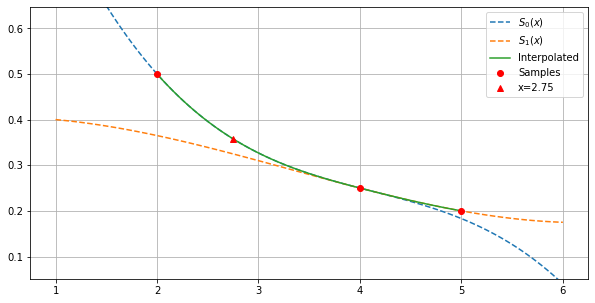

In [47]:
interpolated_vals = PlotCubicSplines(x,y, bound_cond,plot=True)
plt.plot([2.75], Spline3Interpolate(x,y,M,2.75)[0], "r^", label="x=2.75")
plt.legend()

In [340]:
interpolated_vals[1] = [0.68181*i for i in interpolated_vals[1]]
max_speed = 0
is_above55 = False
first_above55 = x[0]
for i in range(len(interpolated_vals)):
    if(interpolated_vals[1][i] > 55 and not is_above55):
        first_above55 = x[i]
        is_above55 = True
    if(max_speed<interpolated_vals[1][i]):
        max_speed = interpolated_vals[1][i]

if(is_above55):
    print("First Point where car's Speed is Greater than 55 is : ", first_above55)
print("Max Speed achieved : ", max_speed)
        

First Point where car's Speed is Greater than 55 is :  0
Max Speed achieved :  63.015483208407474
